# Phân tích dữ liệu

### **Tiền xử lý dữ liệu**
- Lấy dữ liệu từ nguồn (ví dụ: CPI từ cơ quan thống kê).
- Kiểm tra giá trị thiếu, giá trị ngoại lai.
- Xử lý dữ liệu bị lỗi (impute missing values, loại bỏ outliers).
- Chuyển đổi đơn vị nếu cần (log transformation, normalization).


In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi.csv"
df = pd.read_csv(path)

In [ ]:
df

,tg,t,cpi
0,0,Jan-95,103.80
1,1,Feb-95,103.40
2,2,Mar-95,100.20
3,3,Apr-95,101.00
4,4,May-95,101.80
...,...,...,...
355,343,Aug-24,100.00
356,344,Sep-24,100.29
357,345,Oct-24,100.33
358,346,Nov-24,100.13


Dữ liệu gồm 3 cột:

- tg: Chỉ số thời gian (có thể là số thứ tự).
- t: Thời gian dạng MM-YY (tháng-năm).
- cpi: Chỉ số giá tiêu dùng (CPI).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tg      360 non-null    int64  
 1   t       360 non-null    object 
 2   cpi     360 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.6+ KB


In [ ]:
import numpy as np

# Chuyển đổi cột 't' sang dạng datetime
df['t'] = pd.to_datetime(df['t'], format='%b-%y')
df.drop(columns=['tg'], inplace=True)
df.columns = ['time', 'cpi_mom']

In [ ]:
# Chuyển đổi CPI MoM sang hệ số
df["cpi_mom_factor"] = df["cpi_mom"] / 100

# Tính CPI YoY (sau ít nhất 12 tháng mới có giá trị)
df["cpi_yoy"] = df["cpi_mom_factor"].rolling(window=12).apply(lambda x: x.prod(), raw=True) * 100
df["cpi_yoy"] = df["cpi_yoy"].round(2)
df.drop(columns=['cpi_mom_factor'], inplace=True)

df.set_index("time", inplace=True)  # Đặt 'time' làm index

df = df.dropna(subset=["cpi_yoy"])

# Hiển thị kết quả
df

,cpi_mom,cpi_yoy
time,,
1995-12-01,100.30,112.91
1996-01-01,100.90,109.76
1996-02-01,102.50,108.80
1996-03-01,100.80,109.46
1996-04-01,100.10,108.48
...,...,...
2024-08-01,100.00,103.47
2024-09-01,100.29,102.66
2024-10-01,100.33,102.91


In [ ]:
df.to_csv("/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_processed.csv")

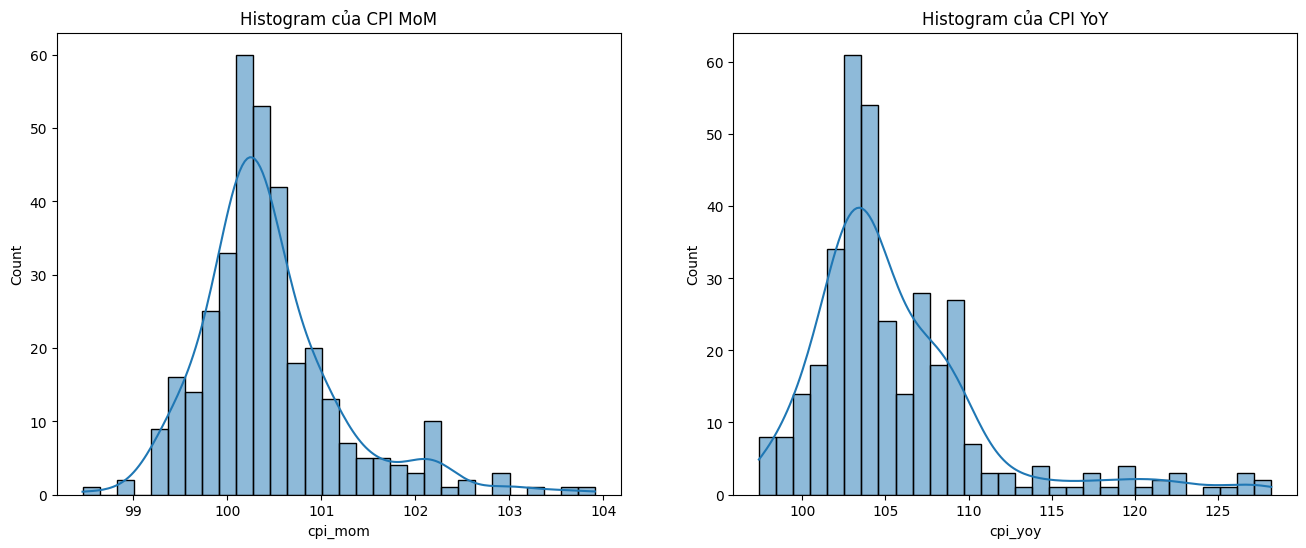

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram của CPI MoM
sns.histplot(df['cpi_mom'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Histogram của CPI MoM")

# Histogram của CPI YoY
sns.histplot(df['cpi_yoy'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Histogram của CPI YoY")

plt.show()


Histogram của CPI MoM và CPI YoY cho thấy cả hai chuỗi có xu hướng lệch phải, đặc biệt là CPI YoY có đuôi dài hơn về phía giá trị cao. Điều này có thể gợi ý rằng chuỗi không tuân theo phân phối chuẩn.

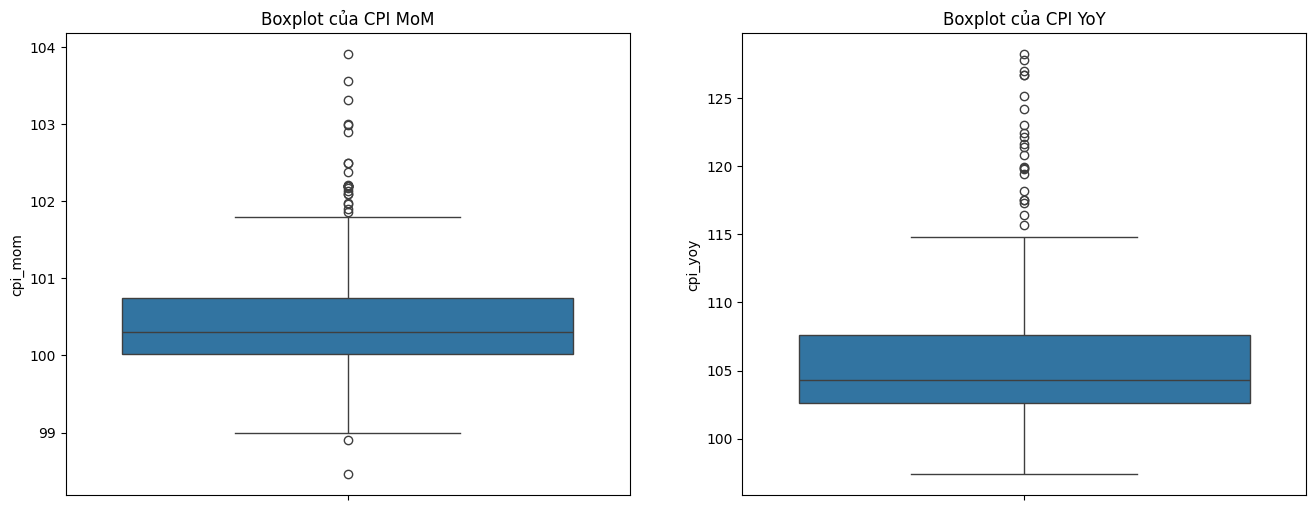

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Vẽ biểu đồ boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(y=df['cpi_mom'], ax=axes[0])
axes[0].set_title("Boxplot của CPI MoM")

sns.boxplot(y=df['cpi_yoy'], ax=axes[1])
axes[1].set_title("Boxplot của CPI YoY")

plt.show()


1. **CPI MoM (Biểu đồ 1)**
   - Có một số lượng lớn outliers phía trên (~102-104).
   - Một vài điểm thấp hơn 99 cũng bị xem là ngoại lệ.
   - Phân phối có vẻ hơi lệch phải.

2. **CPI YoY (Biểu đồ 2)**
   - Nhiều outliers ở phía trên, đặc biệt là các giá trị lớn hơn 120.
   - Điều này phù hợp với histogram trước đó cho thấy phân phối lệch phải.

Trong phân tích kinh tế, dữ liệu chuỗi thời gian thường chứa ngoại lệ (outliers) do tác động của sự kiện bất thường như khủng hoảng tài chính, thiên tai, thay đổi chính sách, hoặc lỗi đo lường.

=> Không nên loại bỏ mà cần dùng mô hình phù hợp.

In [ ]:

# Tính toán IQR và số lượng ngoại lệ
def get_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

# ố lượng outlier trong từng cột
outliers_mom = get_outliers(df['cpi_mom'])
outliers_yoy = get_outliers(df['cpi_yoy'])

print(f"Số lượng outlier trong CPI MoM: {len(outliers_mom)}")
print(outliers_mom)
print(f"Số lượng outlier trong CPI YoY: {len(outliers_yoy)}")
print(outliers_yoy)

Số lượng outlier trong CPI MoM: 26
time
1996-02-01    102.50
1998-02-01    102.20
1999-02-01    101.90
2000-03-01     98.90
2002-02-01    102.20
2003-02-01    102.20
2004-02-01    103.00
2005-02-01    102.50
2006-02-01    102.10
2007-02-01    102.20
2007-12-01    102.90
2008-01-01    102.38
2008-02-01    103.56
2008-03-01    102.99
2008-04-01    102.20
2008-05-01    103.91
2008-06-01    102.14
2010-02-01    101.96
2010-11-01    101.86
2010-12-01    101.98
2011-02-01    102.09
2011-03-01    102.17
2011-04-01    103.32
2011-05-01    102.21
2012-09-01    102.20
2020-04-01     98.46
Name: cpi_mom, dtype: float64
Số lượng outlier trong CPI YoY: 23
time
2008-02-01    115.70
2008-03-01    119.40
2008-04-01    121.42
2008-05-01    125.16
2008-06-01    126.70
2008-07-01    126.99
2008-08-01    128.20
2008-09-01    127.80
2008-10-01    126.67
2008-11-01    124.21
2008-12-01    119.89
2009-01-01    117.48
2011-04-01    117.51
2011-05-01    119.78
2011-06-01    120.82
2011-07-01    122.16
2011-08-

### **Khám phá & Trực quan hóa dữ liệu**
- Vẽ biểu đồ chuỗi thời gian (Time Series Plot) để xem xu hướng.
- Phân tích thống kê: Mean, median, variance, skewness, kurtosis.
- Decomposition (Phân tách): Tách dữ liệu thành xu hướng (trend), mùa vụ (seasonality), phần ngẫu nhiên (residual).

In [ ]:
data = df.copy()
data.head()

,cpi_mom,cpi_yoy,cpi_yoy_diff
time,,,
1996-01-01,100.9,109.76,-3.15
1996-02-01,102.5,108.80,-0.96
1996-03-01,100.8,109.46,0.66
1996-04-01,100.1,108.48,-0.98
1996-05-01,99.5,106.03,-2.45


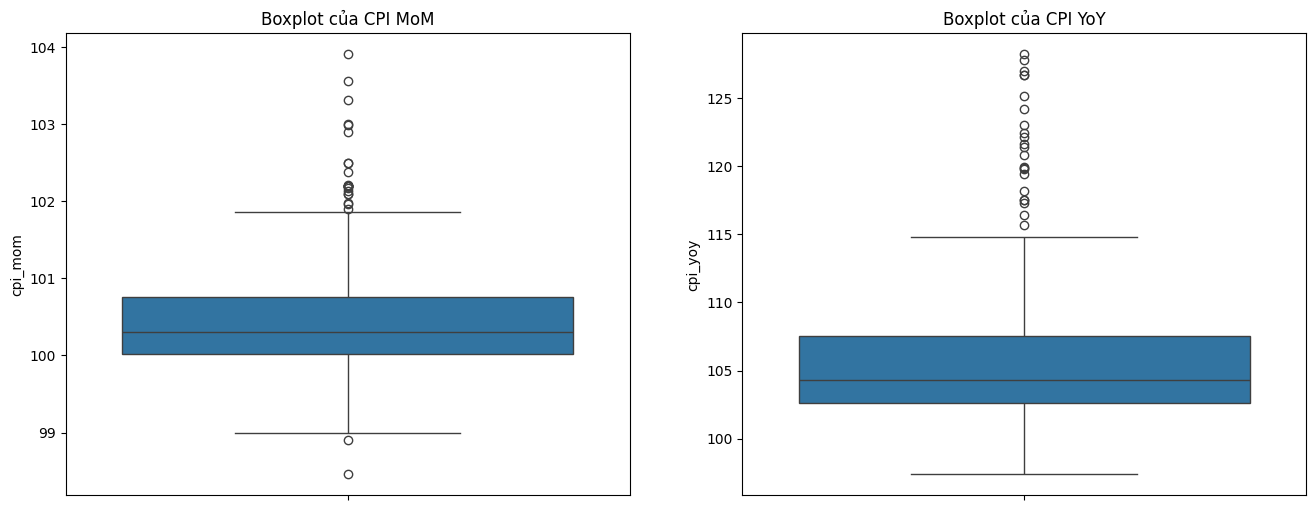

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Vẽ biểu đồ boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(y=data['cpi_mom'], ax=axes[0])
axes[0].set_title("Boxplot của CPI MoM")

sns.boxplot(y=data['cpi_yoy'], ax=axes[1])
axes[1].set_title("Boxplot của CPI YoY")

plt.show()


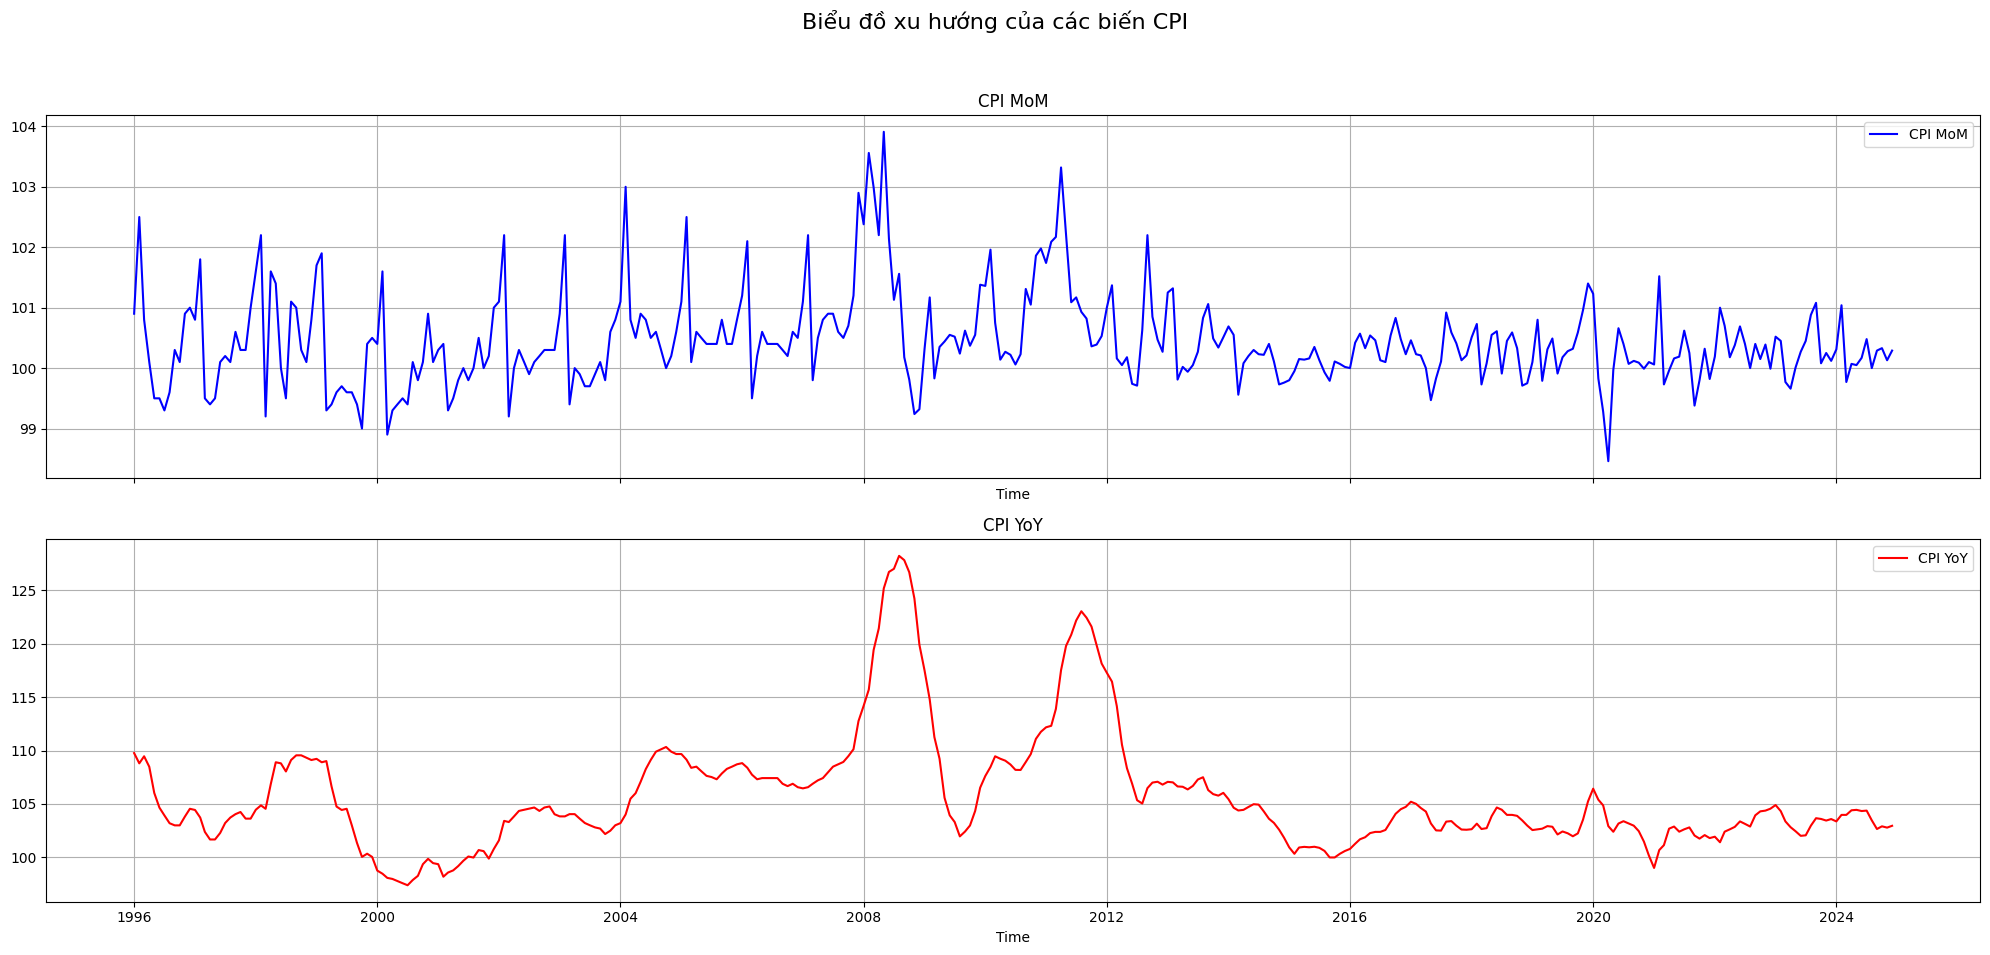

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure với nhiều subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.suptitle("Biểu đồ xu hướng của các biến CPI", fontsize=16)

# Vẽ xu hướng của các biến CPI
axes[0].plot(data.index, data['cpi_mom'], label='CPI MoM', color='b')
axes[0].set_title('CPI MoM')
axes[0].legend()

axes[1].plot(data.index, data['cpi_yoy'], label='CPI YoY', color='r')
axes[1].set_title('CPI YoY')
axes[1].legend()

# Tăng cường hiển thị
for ax in axes:
    ax.grid(True)
    ax.set_xlabel("Time")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Điều chỉnh bố cục để tiêu đề không bị che
plt.show()


- CPI MoM (hàng trên - màu xanh): Dao động mạnh với biến động liên tục theo thời gian.
Có vẻ không có xu hướng dài hạn rõ ràng nhưng có dấu hiệu biến động mạnh vào một số giai đoạn. Khả năng cao có tính chất chu kỳ hoặc mùa vụ.
- CPI YoY (hàng dưới - màu đỏ): Xu hướng dài hạn rõ ràng hơn, có những giai đoạn tăng mạnh rồi giảm xuống. Có những biến động đột ngột, đặc biệt là một số giai đoạn có mức CPI YoY tăng đột biến.

In [ ]:
# Kiểm tra thông tin tổng quan
info = data.info()

# Thống kê mô tả cho cột CPI
summary_stats_mom = data['cpi_mom'].describe()
summary_stats_yoy = data['cpi_yoy'].describe()
info, summary_stats_mom, summary_stats_yoy

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1996-01-01 to 2024-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cpi_mom       348 non-null    float64
 1   cpi_yoy       348 non-null    float64
 2   cpi_yoy_diff  348 non-null    float64
dtypes: float64(3)
memory usage: 10.9 KB


(None,
 count    348.000000
 mean     100.449569
 std        0.762713
 min       98.460000
 25%      100.020000
 50%      100.300000
 75%      100.762500
 max      103.910000
 Name: cpi_mom, dtype: float64,
 count    348.000000
 mean     105.668132
 std        5.398438
 min       97.400000
 25%      102.625000
 50%      104.310000
 75%      107.545000
 max      128.200000
 Name: cpi_yoy, dtype: float64)

### **Kiểm tra dữ liệu**
#### **Kiểm tra tính dừng (ADF Test, KPSS Test)**

- ADF Test (Augmented Dickey-Fuller Test): Kiểm tra tính dừng.
- KPSS Test: Kiểm tra tính xu hướng.
- Lấy sai phân (Differencing) nếu chuỗi không dừng.
- Kiểm tra lại ADF Test sau khi lấy sai phân.

#### **Kiểm tra phương sai của chuỗi**

- Kiểm định ARCH
- Kiểm định Bartlett
- Kiểm định Levene

#### **Kiểm tra mối quan hệ tự tương quan**

- Biểu đồ ACF/PACF
- Kiểm định Ljung-Box
- Kiểm định Durbin-Watson

#### **Kiểm tra phân phối dữ liệu**

- Histogram & KDE Plot (để kiểm tra trực quan)
- Q-Q Plot (để so sánh với phân phối chuẩn)
- Kiểm định Shapiro-Wilk, Kolmogorov-Smirnov, Jarque-Bera (kiểm tra tính chuẩn)

#### **Kiểm tra tính mùa vụ (Seasonality)**

- Vẽ Seasonal Decomposition (sử dụng seasonal_decompose)
- Dùng kiểm định CH Test (Canova-Hansen Test)

#### **Kiểm tra quan hệ nhân quả**
- Granger Causality Test

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# Kiểm định ADF
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"Number of Observations Used: {result[3]}")
    print(f"Critical Values: {result[4]}")
    print("Kết luận:", "Chuỗi có tính dừng (bác bỏ H₀)" if result[1] < 0.05 else "Chuỗi không dừng (không bác bỏ H₀)")
    print("-" * 50)

# Kiểm định KPSS
def kpss_test(series, name):
    statistic, p_value, _, critical_values = kpss(series.dropna(), regression='c', nlags="auto")
    print(f"KPSS Test for {name}")
    print(f"Test Statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Critical Values: {critical_values}")
    print("Kết luận:", "Chuỗi có tính dừng (không bác bỏ H₀)" if p_value > 0.05 else "Chuỗi không dừng (bác bỏ H₀)")
    print("-" * 50)

# Danh sách biến cần kiểm tra
variables = ["cpi_mom", "cpi_yoy"]

# Chạy kiểm định cho từng biến
for var in variables:
    adf_test(df[var], var)
    kpss_test(df[var], var)

# Nếu cả hai test đều nói dừng → chuỗi thực sự dừng.
# Nếu cả hai test đều nói không dừng → cần chuyển đổi dữ liệu (log transformation, differencing).

ADF Test for cpi_mom
ADF Statistic: -3.8058
p-value: 0.0028
Lags Used: 12
Number of Observations Used: 336
Critical Values: {'1%': np.float64(-3.449962981927952), '5%': np.float64(-2.870180642420163), '10%': np.float64(-2.5713734527352607)}
Kết luận: Chuỗi có tính dừng (bác bỏ H₀)
--------------------------------------------------
KPSS Test for cpi_mom
Test Statistic: 0.3336
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Kết luận: Chuỗi có tính dừng (không bác bỏ H₀)
--------------------------------------------------
ADF Test for cpi_yoy
ADF Statistic: -2.7382
p-value: 0.0677
Lags Used: 13
Number of Observations Used: 335
Critical Values: {'1%': np.float64(-3.4500219858626227), '5%': np.float64(-2.870206553997666), '10%': np.float64(-2.571387268879483)}
Kết luận: Chuỗi không dừng (không bác bỏ H₀)
--------------------------------------------------
KPSS Test for cpi_yoy
Test Statistic: 0.3554
p-value: 0.0964
Critical Values: {'10%': 0.347, '5%':

<ipython-input-10-fef2ad30f49e>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series.dropna(), regression='c', nlags="auto")


In [ ]:
# Lấy sai phân để chuỗi CPI YoY dừng
df['cpi_yoy_diff'] = df['cpi_yoy'].diff().dropna()
# Xóa các giá trị null
df = df.dropna(subset=["cpi_yoy_diff"])
adf_test(df['cpi_yoy_diff'], "cpi_yoy_diff")
kpss_test(df['cpi_yoy_diff'], "cpi_yoy_diff")

ADF Test for cpi_yoy_diff
ADF Statistic: -5.2516
p-value: 0.0000
Lags Used: 17
Number of Observations Used: 330
Critical Values: {'1%': np.float64(-3.4503224123605194), '5%': np.float64(-2.870338478726661), '10%': np.float64(-2.571457612488522)}
Kết luận: Chuỗi có tính dừng (bác bỏ H₀)
--------------------------------------------------
KPSS Test for cpi_yoy_diff
Test Statistic: 0.0320
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Kết luận: Chuỗi có tính dừng (không bác bỏ H₀)
--------------------------------------------------


<ipython-input-10-fef2ad30f49e>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series.dropna(), regression='c', nlags="auto")


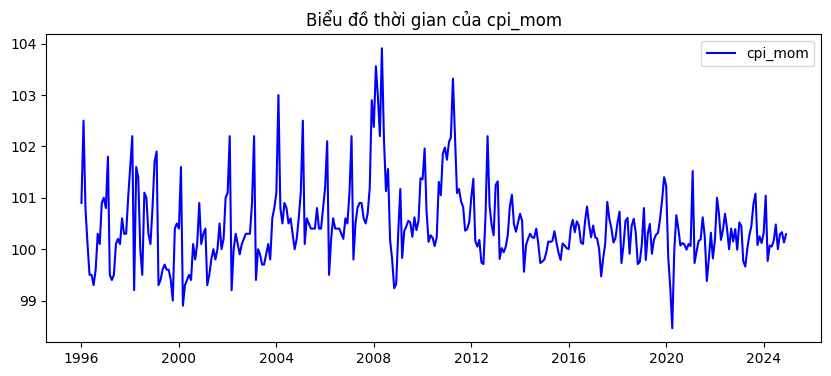

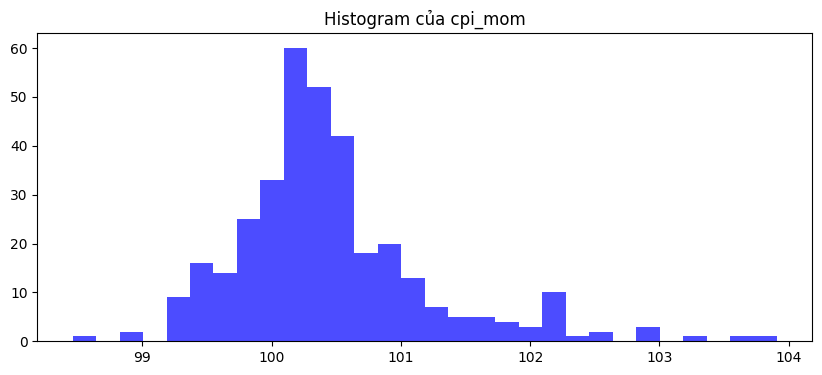

Kiểm định phương sai cho cpi_mom
ARCH Test p-value: 0.0000 → Có dấu hiệu phương sai thay đổi
Bartlett Test p-value: 0.0000 → Phương sai khác nhau
Levene Test p-value: 0.0000 → Phương sai khác nhau
--------------------------------------------------


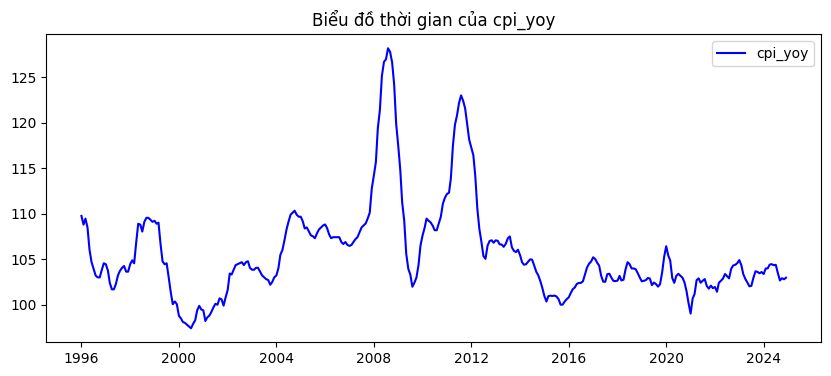

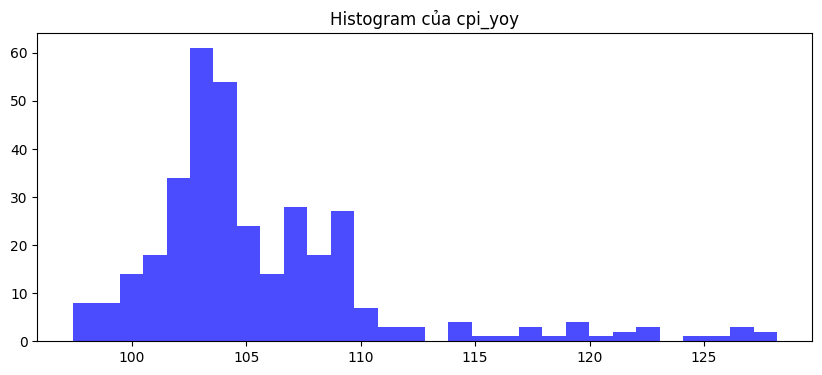

Kiểm định phương sai cho cpi_yoy
ARCH Test p-value: 0.0000 → Có dấu hiệu phương sai thay đổi
Bartlett Test p-value: 0.0000 → Phương sai khác nhau
Levene Test p-value: 0.0000 → Phương sai khác nhau
--------------------------------------------------


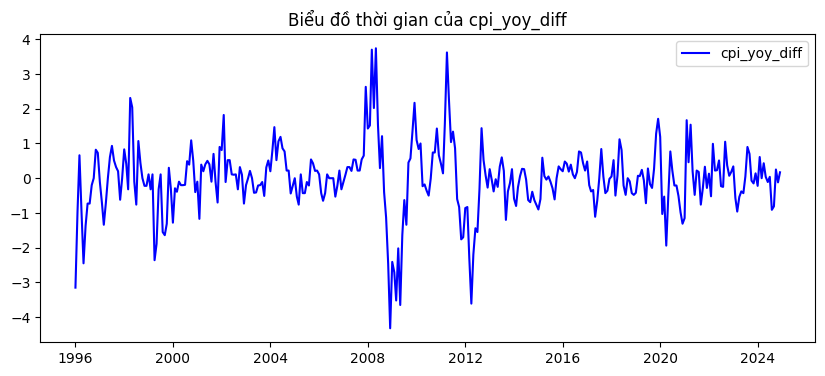

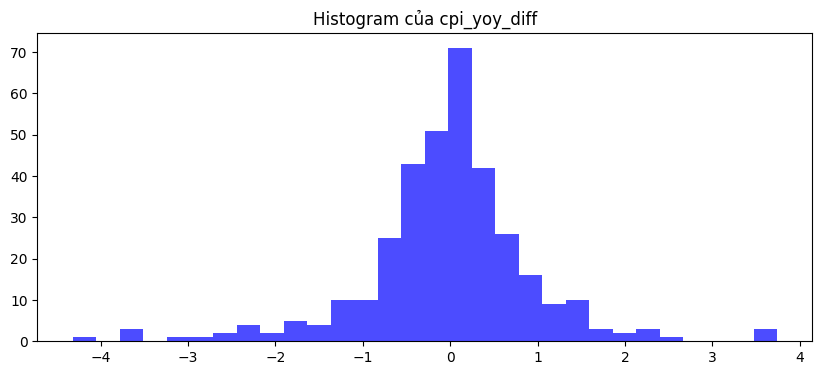

Kiểm định phương sai cho cpi_yoy_diff
ARCH Test p-value: 0.0000 → Có dấu hiệu phương sai thay đổi
Bartlett Test p-value: 0.0516 → Phương sai đồng nhất
Levene Test p-value: 0.4193 → Phương sai đồng nhất
--------------------------------------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan, het_arch
from scipy.stats import bartlett, levene

# Kiểm tra trực quan bằng đồ thị
def plot_variance(series, name):
    plt.figure(figsize=(10, 4))
    plt.plot(series, label=name, color='b')
    plt.title(f"Biểu đồ thời gian của {name}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.hist(series.dropna(), bins=30, alpha=0.7, color='b')
    plt.title(f"Histogram của {name}")
    plt.show()

# Kiểm định phương sai
def variance_tests(series, name):
    print(f"Kiểm định phương sai cho {name}")

    # Kiểm định ARCH (tính phương sai thay đổi theo thời gian)
    arch_test = het_arch(series.dropna())
    print(f"ARCH Test p-value: {arch_test[1]:.4f} → {'Có dấu hiệu phương sai thay đổi' if arch_test[1] < 0.05 else 'Không có dấu hiệu phương sai thay đổi'}")

    # Kiểm định Bartlett (so sánh phương sai giữa các nhóm)
    median_value = np.median(series.dropna())
    group1 = series[series <= median_value].dropna()
    group2 = series[series > median_value].dropna()
    if len(group1) > 1 and len(group2) > 1:
        bartlett_test = bartlett(group1, group2)
        print(f"Bartlett Test p-value: {bartlett_test.pvalue:.4f} → {'Phương sai khác nhau' if bartlett_test.pvalue < 0.05 else 'Phương sai đồng nhất'}")

    # Kiểm định Levene (giống Bartlett nhưng ít nhạy cảm với phân phối)
        levene_test = levene(group1, group2)
        print(f"Levene Test p-value: {levene_test.pvalue:.4f} → {'Phương sai khác nhau' if levene_test.pvalue < 0.05 else 'Phương sai đồng nhất'}")

    print("-" * 50)

# Danh sách biến cần kiểm tra phương sai
variables = ["cpi_mom", "cpi_yoy", "cpi_yoy_diff"]

for var in variables:
    plot_variance(df[var], var)
    variance_tests(df[var], var)

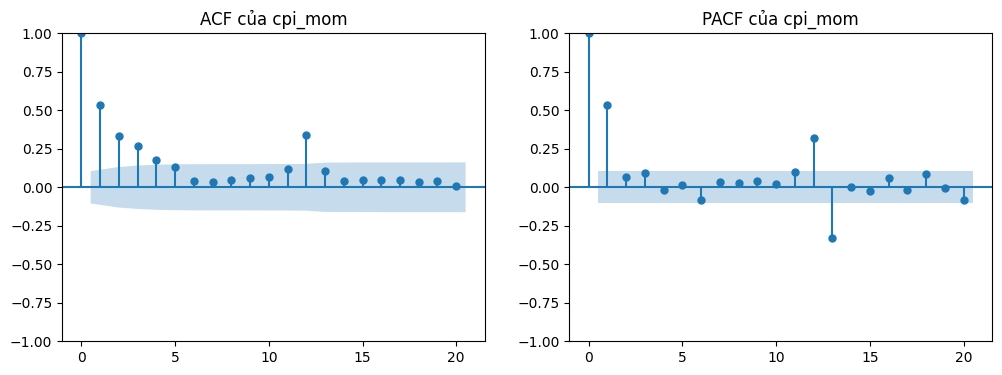

Ljung-Box Test cho cpi_mom (lags=10)
       lb_stat     lb_pvalue
10  187.601798  6.167650e-35
Kết luận: Có tự tương quan
--------------------------------------------------
Durbin-Watson Test cho cpi_mom: 0.0001
Kết luận: Có tự tương quan dương
--------------------------------------------------


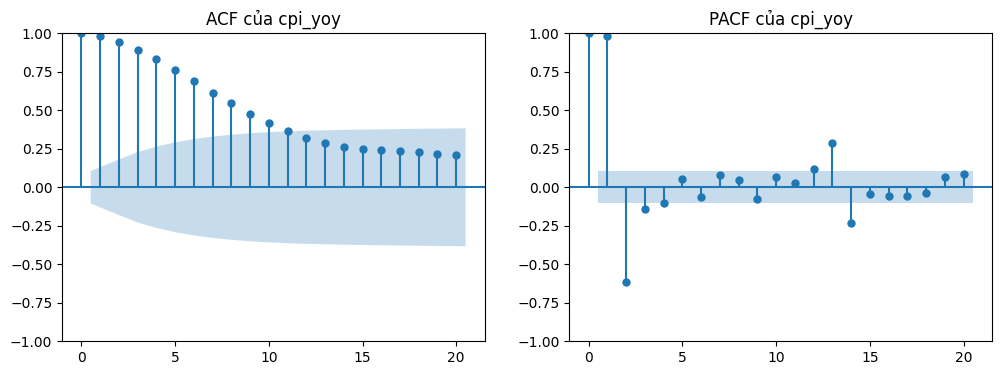

Ljung-Box Test cho cpi_yoy (lags=10)
        lb_stat  lb_pvalue
10  1940.681117        0.0
Kết luận: Có tự tương quan
--------------------------------------------------
Durbin-Watson Test cho cpi_yoy: 0.0001
Kết luận: Có tự tương quan dương
--------------------------------------------------


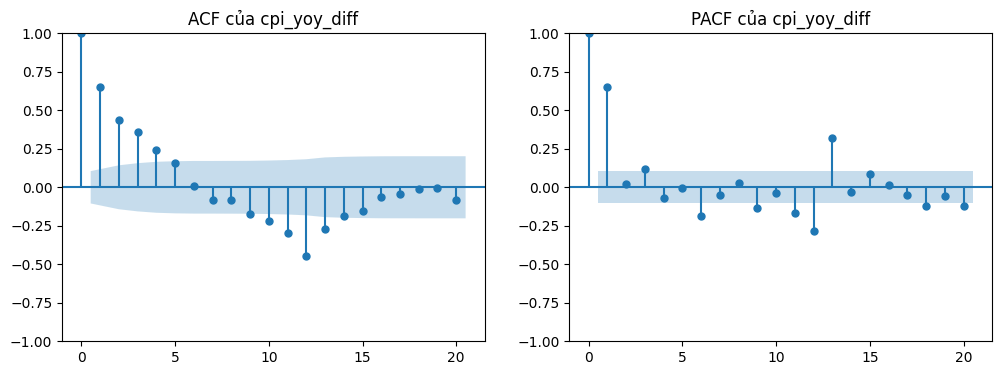

Ljung-Box Test cho cpi_yoy_diff (lags=10)
       lb_stat     lb_pvalue
10  322.924621  2.191333e-63
Kết luận: Có tự tương quan
--------------------------------------------------
Durbin-Watson Test cho cpi_yoy_diff: 0.6727
Kết luận: Có tự tương quan dương
--------------------------------------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

# Hàm vẽ ACF & PACF
def plot_acf_pacf(series, name, lags=20):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series.dropna(), ax=ax[0], lags=lags)
    ax[0].set_title(f"ACF của {name}")

    plot_pacf(series.dropna(), ax=ax[1], lags=lags)
    ax[1].set_title(f"PACF của {name}")

    plt.show()

# Kiểm định Ljung-Box
def ljung_box_test(series, name, lags=10):
    result = acorr_ljungbox(series.dropna(), lags=[lags], return_df=True)
    print(f"Ljung-Box Test cho {name} (lags={lags})")
    print(result)
    print("Kết luận:", "Có tự tương quan" if result['lb_pvalue'].values[0] < 0.05 else "Không có tự tương quan")
    print("-" * 50)

# Kiểm định Durbin-Watson
def durbin_watson_test(series, name):
    dw_stat = durbin_watson(series.dropna())
    print(f"Durbin-Watson Test cho {name}: {dw_stat:.4f}")
    if dw_stat < 1.5:
        print("Kết luận: Có tự tương quan dương")
    elif dw_stat > 2.5:
        print("Kết luận: Có tự tương quan âm")
    else:
        print("Kết luận: Không có tự tương quan")
    print("-" * 50)

# Danh sách biến cần kiểm tra
variables = ["cpi_mom", "cpi_yoy", "cpi_yoy_diff"]

for var in variables:
    plot_acf_pacf(df[var], var)
    ljung_box_test(df[var], var)
    durbin_watson_test(df[var], var)


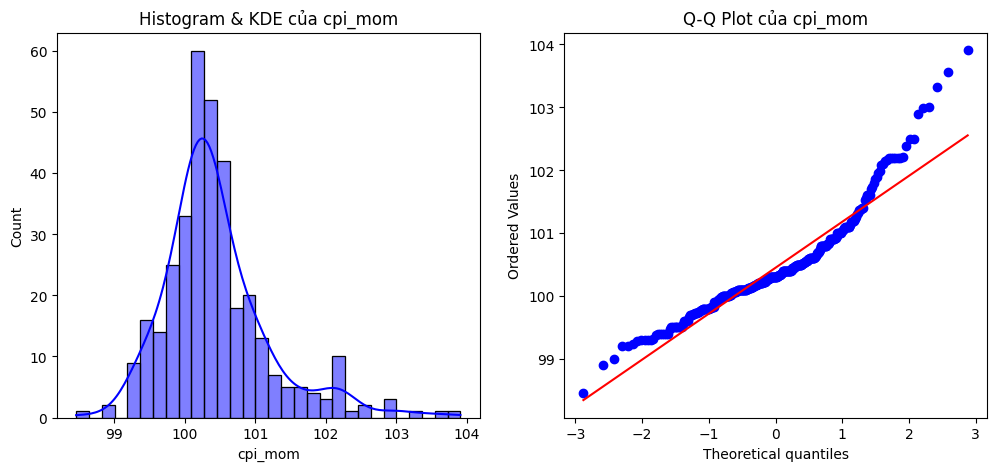

Shapiro-Wilk Test p-value: 0.0000 → Không chuẩn
Jarque-Bera Test p-value: 0.0000 → Không chuẩn
--------------------------------------------------


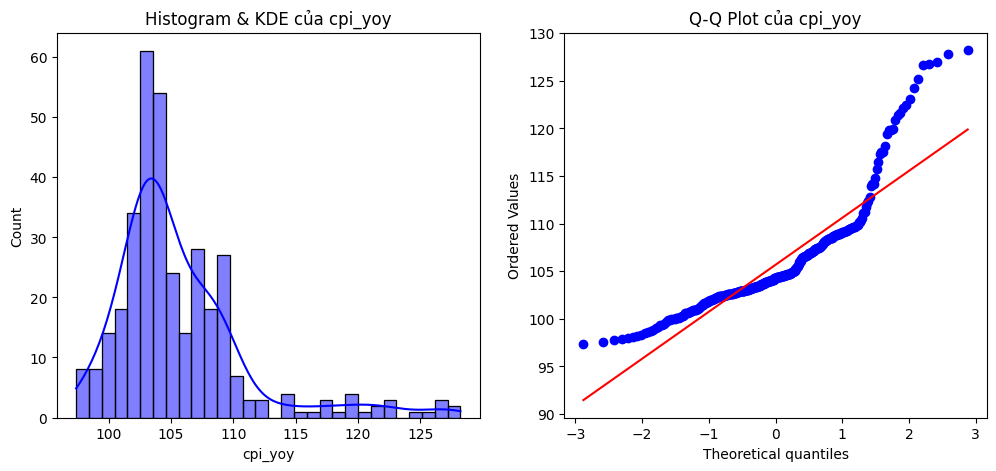

Shapiro-Wilk Test p-value: 0.0000 → Không chuẩn
Jarque-Bera Test p-value: 0.0000 → Không chuẩn
--------------------------------------------------


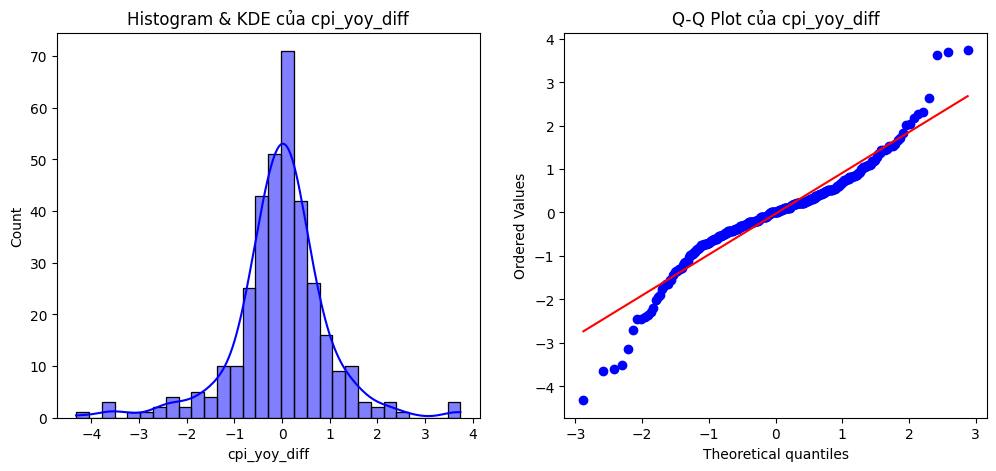

Shapiro-Wilk Test p-value: 0.0000 → Không chuẩn
Jarque-Bera Test p-value: 0.0000 → Không chuẩn
--------------------------------------------------


In [ ]:
import scipy.stats as stats
import seaborn as sns

def check_distribution(series, name):
    plt.figure(figsize=(12, 5))

    # Histogram và KDE
    plt.subplot(1, 2, 1)
    sns.histplot(series.dropna(), kde=True, bins=30, color='b')
    plt.title(f"Histogram & KDE của {name}")

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(series.dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot của {name}")

    plt.show()

    # Kiểm định thống kê
    shapiro_test = stats.shapiro(series.dropna())
    jarque_bera_test = stats.jarque_bera(series.dropna())

    print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue:.4f} → {'Không chuẩn' if shapiro_test.pvalue < 0.05 else 'Chuẩn'}")
    print(f"Jarque-Bera Test p-value: {jarque_bera_test.pvalue:.4f} → {'Không chuẩn' if jarque_bera_test.pvalue < 0.05 else 'Chuẩn'}")
    print("-" * 50)

for var in ["cpi_mom", "cpi_yoy", "cpi_yoy_diff"]:
    check_distribution(df[var], var)


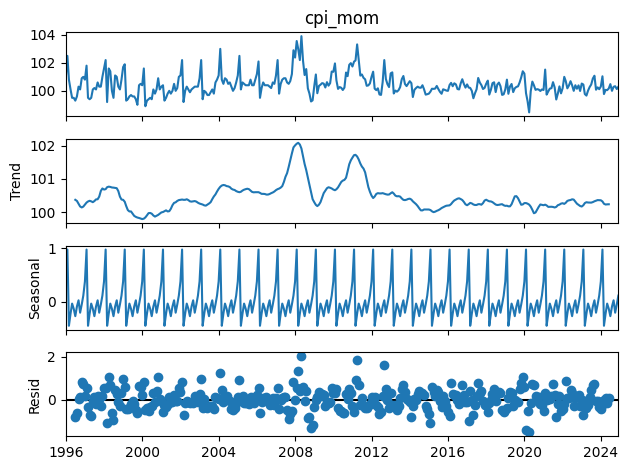

--------------------------------------------------


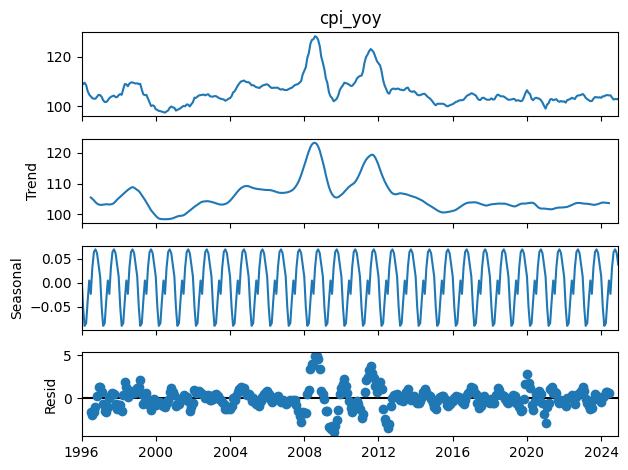

--------------------------------------------------


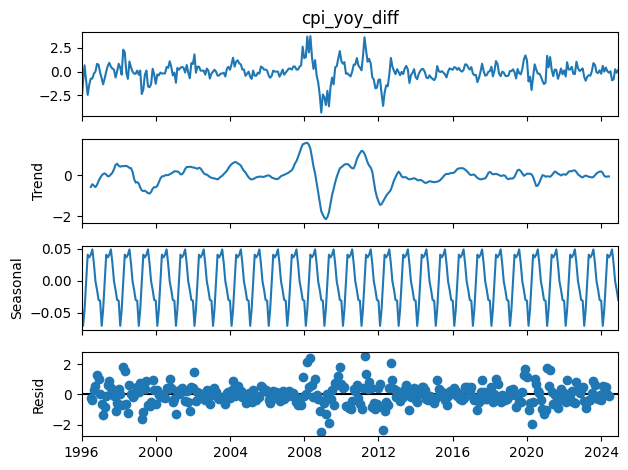

--------------------------------------------------


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

def check_seasonality(series, name, period=12):
    decomposition = seasonal_decompose(series.dropna(), model="additive", period=period)
    decomposition.plot()
    # plt.suptitle(f"Seasonal Decomposition của {name}")
    plt.show()
    print("-" * 50)


for var in ["cpi_mom", "cpi_yoy", "cpi_yoy_diff"]:
    check_seasonality(df[var], var)


In [ ]:
def granger_causality_test(df, var1, var2, max_lag=5):
    print(f"Granger Causality Test giữa {var1} và {var2}")
    test_result = grangercausalitytests(df[[var1, var2]].dropna(), max_lag, verbose=True)
    print("-" * 50)

granger_causality_test(df, "cpi_mom", "cpi_yoy")
granger_causality_test(df, "cpi_mom", "cpi_yoy_diff")
granger_causality_test(df, "cpi_yoy", "cpi_yoy_diff")

Granger Causality Test giữa cpi_mom và cpi_yoy

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1669  , p=0.0135  , df_denom=344, df_num=1
ssr based chi2 test:   chi2=6.2207  , p=0.0126  , df=1
likelihood ratio test: chi2=6.1656  , p=0.0130  , df=1
parameter F test:         F=6.1669  , p=0.0135  , df_denom=344, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0532  , p=0.0026  , df_denom=341, df_num=2
ssr based chi2 test:   chi2=12.2840 , p=0.0022  , df=2
likelihood ratio test: chi2=12.0710 , p=0.0024  , df=2
parameter F test:         F=6.0532  , p=0.0026  , df_denom=341, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8913  , p=0.0355  , df_denom=338, df_num=3
ssr based chi2 test:   chi2=8.8537  , p=0.0313  , df=3
likelihood ratio test: chi2=8.7420  , p=0.0329  , df=3
parameter F test:         F=2.8913  , p=0.0355  , df_denom=338, df_num=3

Granger Causality
number of lags (no zero) 4
s

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.4419  , p=0.6432  , df_denom=342, df_num=2
ssr based chi2 test:   chi2=0.8942  , p=0.6395  , df=2
likelihood ratio test: chi2=0.8930  , p=0.6398  , df=2
parameter F test:         F=425.9207, p=0.0000  , df_denom=342, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9206  , p=0.0341  , df_denom=340, df_num=3
ssr based chi2 test:   chi2=8.8906  , p=0.0308  , df=3
likelihood ratio test: chi2=8.7780  , p=0.0324  , df=3
parameter F test:         F=537.3271, p=0.0000  , df_denom=340, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0228  , p=0.9990  , df_denom=338, df_num=4
ssr based chi2 test:   chi2=0.0928  , p=0.9990  , df=4
likelihood ratio test: chi2=0.0928  , p=0.9990  , df=4
parameter F test:         F=607.9249, p=0.0000  , df_denom=338, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2605  , p=0.9344  , df_denom=336, df_num=5
ssr based chi2 test: 